In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import sys
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
from IPython.display import display 
from PIL import Image
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import os
print(os.listdir("dogs-vs-cats"))
import PIL
from tensorflow.keras.callbacks import ModelCheckpoint
import seaborn as sns

Using TensorFlow backend.


Instructions for updating:
non-resource variables are not supported in the long term
['sampleSubmission.csv', 'test', 'train']


In [2]:
filenames = os.listdir("dogs-vs-cats/train/train")
categories = []
for filename in filenames:
    category = filename.split('.')[0]
    if category == 'dog':
        categories.append(str(1))
    else:
        categories.append(str(0))

df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})
df.head()

,filename,category
0,cat.0.jpg,0
1,cat.1.jpg,0
2,cat.10.jpg,0
3,cat.100.jpg,0
4,cat.1000.jpg,0


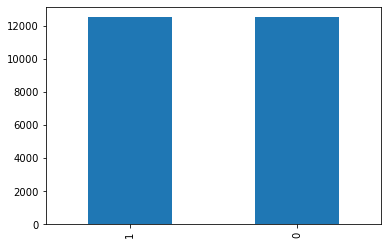

In [3]:
df['category'].value_counts().plot.bar()

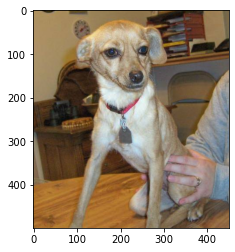

In [4]:
sample = random.choice(filenames)
image = load_img("dogs-vs-cats/train/train/"+sample)
plt.imshow(image)

In [5]:
from keras.models import Sequential
from keras import layers
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation,GlobalMaxPooling2D
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.applications import VGG16
from keras.models import Model

image_size = 224
input_shape = (image_size, image_size, 3)

epochs = 12
batch_size = 8

pre_trained_model = VGG16(input_shape=input_shape, include_top=False, weights="imagenet")
    
for layer in pre_trained_model.layers[:15]:
    layer.trainable = False

for layer in pre_trained_model.layers[15:]:
    layer.trainable = True
    
last_layer = pre_trained_model.get_layer('block5_pool')
last_output = last_layer.output
    
# Flatten the output layer to 1 dimension
x = GlobalMaxPooling2D()(last_output)
# Add a fully connected layer with 512 hidden units and ReLU activation
x = Dense(512, activation='relu')(x)
# Add a dropout rate of 0.5
x = Dropout(0.5)(x)
# Add a final sigmoid layer for classification
x = layers.Dense(1, activation='sigmoid')(x)

model = Model(pre_trained_model.input, x)

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.SGD(lr=5e-5, momentum=0.9), #optimizer=optimizers.SGD(lr=1e-4, momentum=0.9),
              metrics=['accuracy'])

model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
____________________________________________

In [6]:
train_df, validate_df = train_test_split(df, test_size=0.1)
train_df = train_df.reset_index()
validate_df = validate_df.reset_index()

# validate_df = validate_df.sample(n=100).reset_index() # use for fast testing code purpose
# train_df = train_df.sample(n=1800).reset_index() # use for fast testing code purpose

total_train = train_df.shape[0]
total_validate = validate_df.shape[0]

In [7]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    "dogs-vs-cats/train/train/", 
    x_col="filename",
    y_col="category",
    class_mode='binary',
    target_size=(image_size, image_size),
    batch_size=batch_size
)

Found 22500 validated image filenames belonging to 2 classes.


In [8]:
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    "dogs-vs-cats/train/train/", 
    x_col='filename',
    y_col='category',
    class_mode='binary',
    target_size=(image_size, image_size),
    batch_size=batch_size
)

Found 2500 validated image filenames belonging to 2 classes.


In [9]:
#callbacks:

my_callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=2),
    tf.keras.callbacks.TensorBoard(log_dir='logs'),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.1,
        patience=10,
        verbose=0,
        mode="auto",
        min_delta=0.0001,
        cooldown=0,
        min_lr=0)
]


history = model.fit_generator(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=my_callbacks)

Epoch 1/12
2812/2812 [==============================] - 267s 95ms/step - loss: 0.3076 - accuracy: 0.8594 - val_loss: 0.2578 - val_accuracy: 0.9323
Epoch 2/12
2812/2812 [==============================] - 270s 96ms/step - loss: 0.1580 - accuracy: 0.9373 - val_loss: 0.1886 - val_accuracy: 0.9551
Epoch 3/12
2812/2812 [==============================] - 268s 95ms/step - loss: 0.1289 - accuracy: 0.9478 - val_loss: 0.3300 - val_accuracy: 0.9571
Epoch 4/12
2812/2812 [==============================] - 275s 98ms/step - loss: 0.1121 - accuracy: 0.9549 - val_loss: 0.0396 - val_accuracy: 0.9599
Epoch 5/12
2812/2812 [==============================] - 260s 92ms/step - loss: 0.1006 - accuracy: 0.9601 - val_loss: 0.0106 - val_accuracy: 0.9651
Epoch 6/12
2812/2812 [==============================] - 282s 100ms/step - loss: 0.0941 - accuracy: 0.9622 - val_loss: 0.2830 - val_accuracy: 0.9647
Epoch 7/12
2812/2812 [==============================] - 288s 102ms/step - loss: 0.0886 - accuracy: 0.9655 - val_loss:

In [10]:
loss, accuracy = model.evaluate_generator(validation_generator, total_validate//batch_size, workers=12)
print("Test: accuracy = %f  ;  loss = %f " % (accuracy, loss))

Test: accuracy = 0.969151  ;  loss = 0.000628 


C:\Users\govin\Anaconda3\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  
C:\Users\govin\Anaconda3\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:15: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  from ipykernel import kernelapp as app


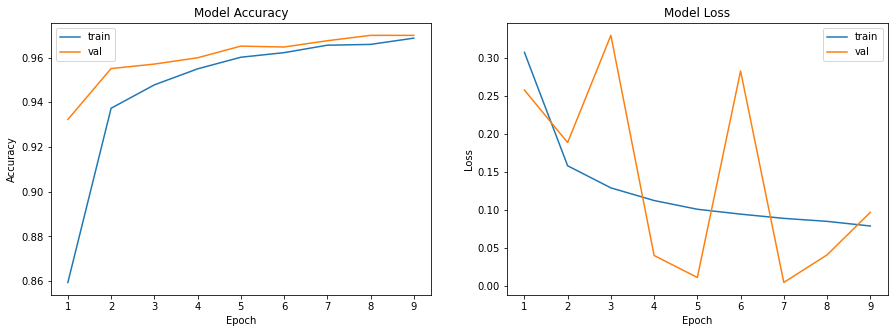

In [11]:
def plot_model_history(model_history, acc='accuracy', val_acc='val_accuracy'):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    axs[0].plot(range(1,len(model_history.history[acc])+1),model_history.history[acc])
    axs[0].plot(range(1,len(model_history.history[val_acc])+1),model_history.history[val_acc])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history[acc])+1),len(model_history.history[acc])/10)
    axs[0].legend(['train', 'val'], loc='best')
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()
    
plot_model_history(history)

In [12]:
Y_val = validate_df['category']
y_pred =  model.predict_generator(validation_generator)

In [13]:
Y_val[0]

'1'

In [14]:
threshold = 0.5
y_final = np.where(y_pred > threshold, 1,0)

In [15]:
y_final.size

2500

In [16]:
# from sklearn.metrics import classification_report

# # Generate a classification report
# report = classification_report(Y_val, y_final, target_names=['0','1'])

# print(report)

In [17]:
test_filenames = os.listdir("dogs-vs-cats/test/test")
test_df = pd.DataFrame({
    'filename': test_filenames
})
nb_samples = test_df.shape[0]

In [18]:
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    test_df, 
    "dogs-vs-cats/test/test/", 
    x_col='filename',
    y_col=None,
    class_mode=None,
    batch_size=batch_size,
    target_size=(image_size, image_size),
    shuffle=False
)

Found 12500 validated image filenames.


In [19]:
predict = model.predict_generator(test_generator, steps=np.ceil(nb_samples/batch_size))
threshold = 0.5
test_df['category'] = np.where(predict > threshold, 1,0)

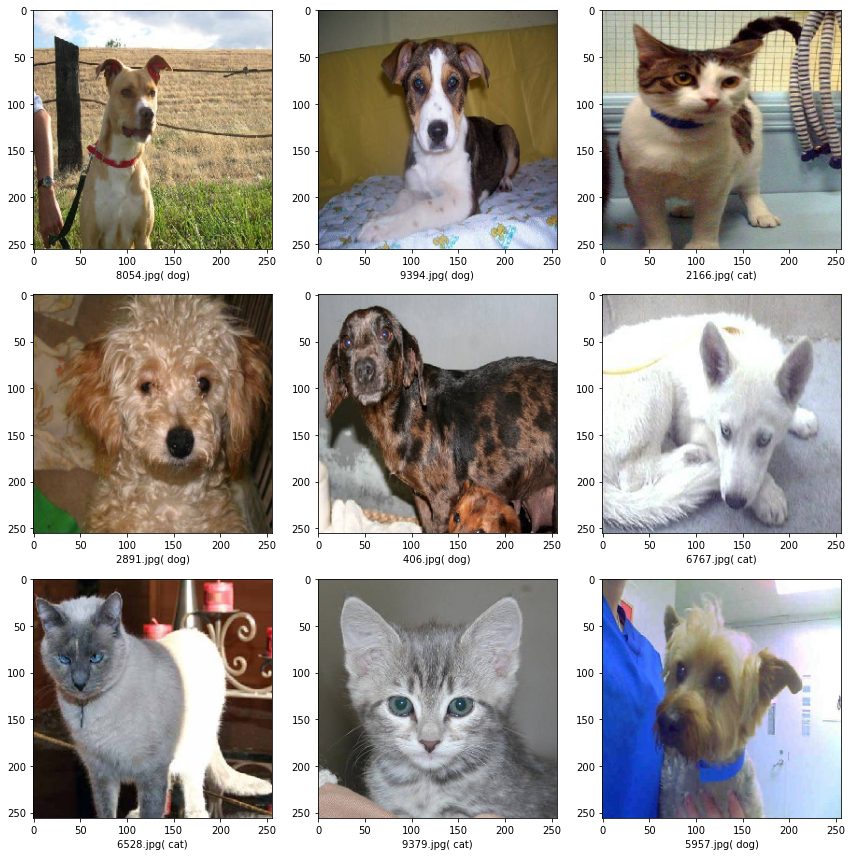

In [20]:
sample_test = test_df.sample(n=9).reset_index()
sample_test.head()
plt.figure(figsize=(12, 12))
for index, row in sample_test.iterrows():
    filename = row['filename']
    category = row['category']
    img = load_img("dogs-vs-cats/test/test/"+filename, target_size=(256, 256))
    plt.subplot(3, 3, index+1)
    plt.imshow(img)
    if category == 0:
        label_plot = ' cat'
    elif category ==1:
        label_plot = ' dog'
    plt.xlabel(filename + '(' + label_plot + ')')
plt.tight_layout()
plt.show()

Text(0.5, 1.0, '(Test data)')

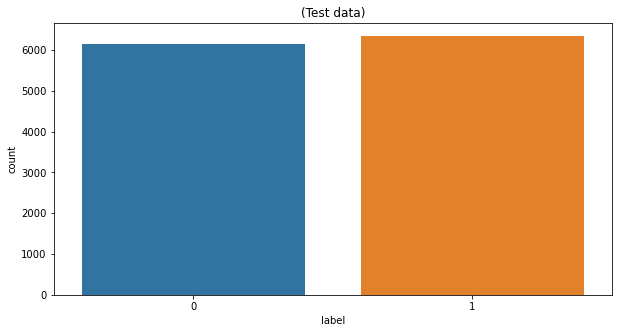

In [21]:
submission_df = test_df.copy()
submission_df['id'] = submission_df['filename'].str.split('.').str[0]
submission_df['label'] = submission_df['category']
submission_df.drop(['filename', 'category'], axis=1, inplace=True)
submission_df.to_csv('Submission_673.csv', index=False)

plt.figure(figsize=(10,5))
sns.countplot(submission_df['label'])
plt.title("(Test data)")